In [5]:
import numpy as np
from StringIO import StringIO
import pandas as pd
from __future__ import division
import matplotlib.pyplot as plt
import urllib2,base64
import cPickle as pickle
from collections import Counter
from collections import defaultdict
from collections import OrderedDict
from __future__ import division
from vincenty import vincenty
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.finance import quotes_historical_yahoo_ochl
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter,DayLocator
from matplotlib.font_manager import FontProperties
import geoplotlib as gp
import scipy as sp
import gdal,ogr
from gdalconst import * 
import datetime
import math
import operator
import re
import os
import os.path
import requests, time
import urllib, json
import csv
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
tls.set_credentials_file(username='ShawnHou', api_key='OohmqCJaPfb6p6xo4pDF')
from geoplotlib.utils import BoundingBox
from sklearn import neighbors, datasets,linear_model,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import LeavePLabelOut
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import r2_score
from pylab import *
from scipy import stats
from sklearn.neighbors import DistanceMetric
from urllib2 import urlopen, Request
from pprint import pprint
import folium
from IPython.display import HTML, display
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
from scipy.spatial import distance
from collections import defaultdict
from operator import itemgetter
from pushover import init, Client
from scipy.spatial import KDTree
from numpy import linalg as LA
from calendar import monthrange
from sklearn import metrics
import tarfile
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from adjustText import adjust_text

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from weatherML import *
#for parallel processing
from ipyparallel import Client

import netCDF4
from netCDF4 import Dataset


import skimage as ski
from skimage import filters
from skimage import exposure
from skimage.io import imread, show
from skimage.filters import try_all_threshold
from skimage.viewer import ImageViewer
%matplotlib inline

***
## Weather Data processing (Bil & Netcdf)
*** 

In [6]:
temp_stations = pd.read_csv(os.getcwd()+'\\data\\data option one\\weather_station_list.csv',skipinitialspace=True)
temp_stations['GHCND']=temp_stations.GHCND.str.strip()
temp_stations=temp_stations[temp_stations.GHCND.str.contains("US")] ##Discard non US stations
temp_stations_clean=temp_stations[np.abs(temp_stations.LON-temp_stations.LON.mean())<=(5*temp_stations.LON.std())] ##discard OUTLIER by location

print "include outliner, size:",temp_stations.shape
print "exclude outliner, size:",temp_stations_clean.shape

include outliner, size: (56918, 6)
exclude outliner, size: (56911, 6)


In [7]:
used_columns = [0,1,2,3,7]
dtypes = ['object']+['object']+['object']+[float, 'object']
data_columns = ['GHCND', 'DATE', 'ATTRIBUTE', 'VALUE', 'TIME']

year_file=os.getcwd()+'\\data\\data option one\\1980.csv.gz'
year_df = pd.read_csv(year_file, compression='gzip', header=None,usecols = used_columns,
                              dtype=dict(zip(used_columns, dtypes)),sep=',').rename(columns=dict(zip(used_columns, data_columns)))
metrics=year_df['ATTRIBUTE'].unique().tolist()
print "All different weather metrics: ",metrics 

All different weather metrics:  ['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'ACMH', 'ACSH', 'PGTM', 'PSUN', 'TSUN', 'WDFG', 'WDFM', 'WSFG', 'WSFM', 'WT01', 'WT16', 'WDF1', 'WSF1', 'WESD', 'TOBS', 'EVAP', 'WDMV', 'WT08', 'MNPN', 'MXPN', 'WT06', 'WT02', 'WT18', 'MDPR', 'WT04', 'DAPR', 'WT09', 'WT03', 'MDSF', 'DWPR', 'WT05', 'DAEV', 'DAWM', 'MDEV', 'MDWM', 'DASF', 'WT14', 'WT11', 'WT07', 'WT22', 'DATX', 'MDTX', 'DATN', 'MDTN']


* ** GET ALL WEATHER STATIONS IN GHCND NETWORK**

In [8]:
temp_stations_clean=pd.read_csv('data\\data option one\\cleaned_weather_station_list_withCounty.csv',skipinitialspace=True)

In [9]:
temp_stations_clean.dtypes

GHCND           object
LAT            float64
LON            float64
ELEV           float64
ST              object
NAME            object
COUNTY_CODE    float64
COUNTY_NAME     object
BLOCK_CODE     float64
dtype: object

* **SELECT ALL NOAA STATIONS IN CONTIGUIOUS US (temp_stations_cont)**

In [10]:
#Get all stations on the contiguious us
temp_stations_clean['ST']=temp_stations_clean['ST'].str.strip()
temp_stations_cont= temp_stations_clean.loc[~temp_stations_clean.index.isin(temp_stations_clean[temp_stations_clean['ST'].isin(['AK','PR','PW','HI','UM','PI'])].index)]

* **DEFINE FUNCTIONS FOR PRISM & NCEP LOOKUP**

In [11]:
def getWeatherNormalPRIMS(locs_df, img): ####USed for TMAX/TMIN/PRCP
    band = img.GetRasterBand(1)
    nodatavalue = band.GetNoDataValue()
    ncol = img.RasterXSize
    nrow = img.RasterYSize
    geotransform = img.GetGeoTransform()
    originX = geotransform[0]
    b=geotransform[2]
    originY = geotransform[3]
    pixelWidth = geotransform[1]
    d=geotransform[4]
    pixelHeight = geotransform[5]
    data = band.ReadAsArray()
    data[data == nodatavalue] = np.nan
    data_ind_array= np.argwhere(~np.isnan(data)).astype(float)
    
    points_list = np.array(zip(locs_df.LAT, locs_df.LON)) #list of X,Y coordinates
    values_list=list()
    for point in points_list:
        row = int((point[0] - originY) / pixelHeight)
        col = int((point[1] - originX) / pixelWidth)
        #print point[0],point[1], row,col, data[row][col]
        values_list.append(data[row][col])
        
    return np.array(values_list)

############################################################################################################################################


def getWeatherNormalNCEP(locs_df,Dataset, M, date): ##HUM/CC/WIND   datafram [LAT,LON] ; Dataset; Metrics; Date
    year=date[:4]
    timestamp=date+'000000'
    dt=datetime.datetime.strptime(timestamp,'%Y%m%d%H%M%S')
    
    #time_var = Dataset['uwnd'].variables['time']
    #first = netCDF4.num2date(time_var[0],time_var.units)
    #last = netCDF4.num2date(time_var[-1],time_var.units)
    first_date = year+"0101"
    last_date = year+"1231"
    
    date_range=np.array([d.strftime('%Y%m%d') for d in pd.date_range(first_date,last_date)])
    date_index, =np.where( date_range==date )
    
    #topoin,lons = shiftgrid(180.,topoin,Dataset.variables['lon'][:],start=False)
    #lat_idx = np.abs(lats - darwin['lat']).argmin()
    #lon_idx = np.abs(lons - darwin['lon']).argmin()
    data_list=list()
    if M=="HUM":
        rhum_var = Dataset.variables['rhum'][:]
        rhum_var[rhum_var==-32767]=np.nan
        #rhum_var,lons = shiftgrid(180.,rhum_var,Dataset.variables['lon'][:],start=False)
        #rhum_var = Dataset.variables['rhum'][date_index,0,41.87,-87.62]
        lats=Dataset.variables['lat'][:]
        lons=Dataset.variables['lon'][:]
        for index, row in locs_df.iterrows():          
            lat_idx = np.abs(lats - row['LAT']).argmin()
            lon_idx = np.abs(lons - (row['LON'] % 360)).argmin()
            #print date_index[0],lat_idx,lon_idx
            rhum_var = Dataset.variables['rhum'][date_index[0],0,lat_idx,lon_idx]
            data_list.append(rhum_var)
            
    if M=="CC":
        tcdc_var = Dataset.variables['tcdc'][:]
        tcdc_var[tcdc_var==-32767]=np.nan
        #tcdc_var,lons = shiftgrid(180.,tcdc_var,Dataset.variables['lon'][:],start=False)
        lats=Dataset.variables['lat'][:]
        lons=Dataset.variables['lon'][:]
        for index, row in locs_df[['LAT','LON']].iterrows():          
            lat_idx = np.abs(lats - row['LAT']).argmin()
            lon_idx = np.abs(lons - (row['LON'] % 360)).argmin() 
            tcdc_var = Dataset.variables['tcdc'][date_index[0],lat_idx,lon_idx]
            data_list.append(tcdc_var)
    
    if M=="WIND":
        uwind_var = Dataset['uwnd'].variables['uwnd'][:]
        vwind_var = Dataset['vwnd'].variables['vwnd'][:]
        uwind_var[uwind_var==-32767]=np.nan
        vwind_var[vwind_var==-32767]=np.nan
        #uwind_var,uwind_lons = shiftgrid(180.,uwind_var,Dataset['uwnd'].variables['lon'][:],start=False)
        #vwind_var,vwind_lons = shiftgrid(180.,vwind_var,Dataset['vwnd'].variables['lon'][:],start=False)
        uwind_lats=Dataset['uwnd'].variables['lat'][:]
        vwind_lats=Dataset['vwnd'].variables['lat'][:]
        uwind_lons=Dataset['uwnd'].variables['lon'][:]
        vwind_lons=Dataset['vwnd'].variables['lon'][:]
        for index, row in locs_df[['LAT','LON']].iterrows():          
            ulat_idx = np.abs(uwind_lats - row['LAT']).argmin()
            ulon_idx = np.abs(uwind_lons - (row['LON'] % 360)).argmin() 
            vlat_idx = np.abs(vwind_lats - row['LAT']).argmin()
            vlon_idx = np.abs(vwind_lons - (row['LON'] % 360)).argmin() 
            
            uwind_var = Dataset['uwnd'].variables['uwnd'][date_index[0],0,ulat_idx,ulon_idx]
            vwind_var = Dataset['vwnd'].variables['vwnd'][date_index[0],0,vlat_idx,vlon_idx]
            
            wind_var=math.sqrt(math.pow(uwind_var,2)+ math.pow(vwind_var,2))
            data_list.append(wind_var)
    #print lons
    #index=netCDF4.date2num(dt,Dataset.variables['time'].units)
    return np.array(data_list)

############################################################################################################################################

### Combine PRISM & NCEP model together for any given location
def combinePRISMnNCEP(prism_df, ncep_df):
    weather_df=prism_df.merge(ncep_df, left_on=['LAT','LON','DATE'], right_on=['LAT','LON','DATE'], how='outer')
    print weather_df
    
############################################################################################################################################




* **DEFINE 30-year NORM Functions (Parallel)**

In [12]:
def getPRISM_30Norm_Parallel(locs_df, norm, date):
    years=range(1981, 2011)
    yearly_list=list()
    leap_years=[1984,1988,1992,1996,2000,2004,2008]
    for year in years:
        if (date=="0229") & (year not in leap_years):
            continue
        
        yearly_date=str(year)+date
        year=str(year)
        if norm=="PRCP":
            filename=r'/vsizip/C:\WorkingGround\Master Thesis\data\daily PRISM dataframes\PRISM_'+"PPT".lower()+'_stable_4kmD2_'+year+'0101_'+year+'1231_bil.zip\PRISM_'+"PPT".lower()+'_stable_4kmD2_'+yearly_date+'_bil.bil'
        else:
            filename=r'/vsizip/C:\WorkingGround\Master Thesis\data\daily PRISM dataframes\PRISM_'+norm.lower()+'_stable_4kmD1_'+year+'0101_'+year+'1231_bil.zip\PRISM_'+norm.lower()+'_stable_4kmD1_'+yearly_date+'_bil.bil'
        gdal.GetDriverByName('EHdr').Register()
        img = gdal.Open(filename, GA_ReadOnly)
        #print filename
        norm_list=getWeatherNormalPRIMS(locs_df,img)
        yearly_list.append(norm_list)
    
    yearly_list=np.array(yearly_list)
    return (np.mean(yearly_list,axis=0),np.std(yearly_list,axis=0))

def getPRISM_30GridNorm_Parallel(norm,date):
    years=range(1981, 2011)
    yearly_list=list()
    leap_years=[1984,1988,1992,1996,2000,2004,2008]
    for year in years:
        if (date=="0229") & (year not in leap_years):
            continue
        
        yearly_date=str(year)+date
        year=str(year)
        if norm=="PRCP":
            filename=r'/vsizip/C:\WorkingGround\Master Thesis\data\daily PRISM dataframes\PRISM_'+"PPT".lower()+'_stable_4kmD2_'+year+'0101_'+year+'1231_bil.zip\PRISM_'+"PPT".lower()+'_stable_4kmD2_'+yearly_date+'_bil.bil'
        else:
            filename=r'/vsizip/C:\WorkingGround\Master Thesis\data\daily PRISM dataframes\PRISM_'+norm.lower()+'_stable_4kmD1_'+year+'0101_'+year+'1231_bil.zip\PRISM_'+norm.lower()+'_stable_4kmD1_'+yearly_date+'_bil.bil'
        gdal.GetDriverByName('EHdr').Register()
        img = gdal.Open(filename, GA_ReadOnly)
        band = img.GetRasterBand(1)
        nodatavalue = band.GetNoDataValue()
        prism_array = band.ReadAsArray().astype(np.float32)
        prism_array[prism_array == nodatavalue] = np.nan
        #print filename
        yearly_list.append(prism_array)
    
    yearly_list=np.array(yearly_list)
    return (np.mean(yearly_list,axis=0),np.std(yearly_list,axis=0))  

def getPRISM_27GridNorm_Parallel(norm,date):
    years=range(1981, 2008)
    yearly_list=list()
    leap_years=[1984,1988,1992,1996,2000,2004,2008]
    for year in years:
        if (date=="0229") & (year not in leap_years):
            continue
        
        yearly_date=str(year)+date
        year=str(year)
        
        if norm=="PRCP":
            filename=r'/vsizip/C:\WorkingGround\Master Thesis\data\daily PRISM dataframes\PRISM_'+"PPT".lower()+'_stable_4kmD2_'+year+'0101_'+year+'1231_bil.zip\PRISM_'+"PPT".lower()+'_stable_4kmD2_'+yearly_date+'_bil.bil'
        else:
            filename=r'/vsizip/C:\WorkingGround\Master Thesis\data\daily PRISM dataframes\PRISM_'+norm.lower()+'_stable_4kmD1_'+year+'0101_'+year+'1231_bil.zip\PRISM_'+norm.lower()+'_stable_4kmD1_'+yearly_date+'_bil.bil'
        gdal.GetDriverByName('EHdr').Register()
        img = gdal.Open(filename, GA_ReadOnly)
        band = img.GetRasterBand(1)
        nodatavalue = band.GetNoDataValue()
        prism_array = band.ReadAsArray().astype(np.float32)
        prism_array[prism_array == nodatavalue] = np.nan
        #print filename
        yearly_list.append(prism_array)
    
    yearly_list=np.array(yearly_list)
    return (np.mean(yearly_list,axis=0),np.std(yearly_list,axis=0))  


def getNCEP_30Norm_Parallel(locs_df, norm, date):
    years=range(1981, 2011)
    yearly_list=list()
    leap_years=[1984,1988,1992,1996,2000,2004,2008]
    for year in years:
        if (date=="0229") & (year not in leap_years):
            continue
        
        yearly_date=str(year)+date
        year=str(year)
        if norm=="HUM":
            ncep_data=Dataset('data\\daily NCEP dataframes\\rhum.'+year+'.nc')
            norm_list=getWeatherNormalNCEP(locs_df,ncep_data, norm,yearly_date)
        if norm=="CC":
            ncep_data=Dataset('data\\daily NCEP dataframes\\tcdc.eatm.gauss.'+year+'.nc')
            norm_list=getWeatherNormalNCEP(locs_df,ncep_data, norm,yearly_date)
        if norm=="WIND":
            ncep_data_vwind=Dataset('data\\daily NCEP dataframes\\vwnd.10m.gauss.'+year+'.nc')
            ncep_data_uwind=Dataset('data\\daily NCEP dataframes\\uwnd.10m.gauss.'+year+'.nc')
            ncep_data=dict()
            ncep_data['uwnd']=ncep_data_uwind
            ncep_data['vwnd']=ncep_data_vwind
            norm_list=getWeatherNormalNCEP(locs_df,ncep_data, norm,yearly_date)

        yearly_list.append(norm_list)
    
    yearly_list=np.array(yearly_list)
    return (np.mean(yearly_list,axis=0),np.std(yearly_list,axis=0))

def getNCEP_30GridNorm_Parallel(norm, date):
    years=range(1981, 2011)
    yearly_list=list()
    leap_years=[1984,1988,1992,1996,2000,2004,2008]
    for year in years:
        if (date=="0229") & (year not in leap_years):
            continue
        
        yearly_date=str(year)+date
        year=str(year)

        first_date = year+"0101"
        last_date = year+"1231"                
        date_range=np.array([d.strftime('%m%d') for d in pd.date_range(first_date,last_date)])
        date_index, =np.where( date_range==date )       
        
        if norm=="HUM":
            ncep_data=Dataset('data\\daily NCEP dataframes\\rhum.'+year+'.nc')
            dataset_vars = ncep_data.variables['rhum'][date_index[0],0,:,:]
            dataset_vars[dataset_vars==-32767]=np.nan
        if norm=="CC":
            ncep_data=Dataset('data\\daily NCEP dataframes\\tcdc.eatm.gauss.'+year+'.nc')
            dataset_vars = ncep_data.variables['tcdc'][date_index[0],:,:]
            dataset_vars[dataset_vars==-32767]=np.nan
        if norm=="WIND":
            ncep_data_vwind=Dataset('data\\daily NCEP dataframes\\vwnd.10m.gauss.'+year+'.nc')
            ncep_data_uwind=Dataset('data\\daily NCEP dataframes\\uwnd.10m.gauss.'+year+'.nc')
            uwind_var = ncep_data_uwind.variables['uwnd'][date_index[0],0,:,:]
            vwind_var = ncep_data_vwind.variables['vwnd'][date_index[0],0,:,:]
            uwind_var[uwind_var==-32767]=np.nan
            vwind_var[vwind_var==-32767]=np.nan
            dataset_vars=np.array([uwind_var,vwind_var])
            dataset_vars=LA.norm(dataset_vars, axis=0)
        
        yearly_list.append(dataset_vars)
    
    yearly_list=np.array(yearly_list)
    return (np.mean(yearly_list,axis=0),np.std(yearly_list,axis=0))

def getNCEP_27GridNorm_Parallel(norm, date):
    years=range(1981, 2008)
    yearly_list=list()
    leap_years=[1984,1988,1992,1996,2000,2004,2008]
    for year in years:
        if (date=="0229") & (year not in leap_years):
            continue
        
        yearly_date=str(year)+date
        year=str(year)
        
        first_date = year+"0101"
        last_date = year+"1231"                
        date_range=np.array([d.strftime('%m%d') for d in pd.date_range(first_date,last_date)])
        date_index, =np.where( date_range==date )   
        
        if norm=="HUM":
            ncep_data=Dataset('data\\daily NCEP dataframes\\rhum.'+year+'.nc')
            dataset_vars = ncep_data.variables['rhum'][date_index[0],0,:,:]
            dataset_vars[dataset_vars==-32767]=np.nan
        if norm=="CC":
            ncep_data=Dataset('data\\daily NCEP dataframes\\tcdc.eatm.gauss.'+year+'.nc')
            dataset_vars = ncep_data.variables['tcdc'][date_index[0],:,:]
            dataset_vars[dataset_vars==-32767]=np.nan
        if norm=="WIND":
            ncep_data_vwind=Dataset('data\\daily NCEP dataframes\\vwnd.10m.gauss.'+year+'.nc')
            ncep_data_uwind=Dataset('data\\daily NCEP dataframes\\uwnd.10m.gauss.'+year+'.nc')
            uwind_var = ncep_data_uwind.variables['uwnd'][date_index[0],0,:,:]
            vwind_var = ncep_data_vwind.variables['vwnd'][date_index[0],0,:,:]
            uwind_var[uwind_var==-32767]=np.nan
            vwind_var[vwind_var==-32767]=np.nan
            dataset_vars=np.array([uwind_var,vwind_var])
            dataset_vars=LA.norm(dataset_vars, axis=0)
            
        yearly_list.append(dataset_vars)
    
    yearly_list=np.array(yearly_list)
    return (np.mean(yearly_list,axis=0),np.std(yearly_list,axis=0))

In [196]:
###SAVE PRISM MEAN & STD into PICKLES
date_range=np.array([d.strftime('%m%d') for d in pd.date_range('20160101','20161231')])
prism_keys=['TMAX','TMIN','PRCP']
for prism_key in prism_keys:
    prism_summary_dict=dict()
    for date in date_range:
        prism_summary=getPRISM_30GridNorm_Parallel(prism_key,date)
        prism_summary_dict[date]=prism_summary

    with open('data/'+prism_key+'_mean.pickle', 'wb') as handle:
        pickle.dump(prism_summary_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
#with open('filename.pickle', 'rb') as handle:
#    b = pickle.load(handle)

KeyboardInterrupt: 

In [226]:
###SAVE SHORTER PRISM MEAN & STD into PICKLES
date_range=np.array([d.strftime('%m%d') for d in pd.date_range('20160101','20161231')])
prism_keys=['TMAX','TMIN','PRCP']
for prism_key in prism_keys:
    prism_summary_dict=dict()
    for date in date_range:
        prism_summary=getPRISM_27GridNorm_Parallel(prism_key,date)
        prism_summary_dict[date]=prism_summary

    with open('data/'+prism_key+'_shorter_mean.pickle', 'wb') as handle:
        pickle.dump(prism_summary_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
#with open('filename.pickle', 'rb') as handle:
#    b = pickle.load(handle)

In [228]:
###SAVE NCEP MEAN & STD into PICKLES
date_range=np.array([d.strftime('%m%d') for d in pd.date_range('20160101','20161231')])
ncep_keys=['HUM','CC','WIND']
for ncep_key in ncep_keys:
    ncep_summary_dict=dict()
    for date in date_range:
        ncep_summary=getNCEP_30GridNorm_Parallel(ncep_key,date)
        ncep_summary_dict[date]=ncep_summary

    with open('data/'+ncep_key+'_mean.pickle', 'wb') as handle:
        pickle.dump(ncep_summary_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [229]:
###SAVE SHORTER NCEP MEAN & STD into PICKLES
date_range=np.array([d.strftime('%m%d') for d in pd.date_range('20160101','20161231')])
ncep_keys=['HUM','CC','WIND']
for ncep_key in ncep_keys:
    ncep_summary_dict=dict()
    for date in date_range:
        ncep_summary=getNCEP_27GridNorm_Parallel(ncep_key,date)
        ncep_summary_dict[date]=ncep_summary

    with open('data/'+ncep_key+'_shorter_mean.pickle', 'wb') as handle:
        pickle.dump(ncep_summary_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

***
## Population Density Processing (TIF File)
***

In [13]:
def tifdump(fp):
    img = gdal.Open(fp)
    band = img.GetRasterBand(1)
    # Compute statistics if needed
    nodatavalue = band.GetNoDataValue()
    
    ncol = img.RasterXSize
    nrow = img.RasterYSize
    geotransform = img.GetGeoTransform()
    originX = geotransform[0]
    pixelWidth = geotransform[1]
    b=geotransform[2]
    originY = geotransform[3]
    d=geotransform[4]
    pixelHeight = geotransform[5]
    
    
    if band.GetMinimum() is None or band.GetMaximum()is None:
        band.ComputeStatistics(0)
        print("Statistics computed.")

    # Fetch metadata for the band
    print band.GetMetadata()
    print "**********************"
    print "Projection: (OriginX, pixelWidth,b, OriginY, pixelHeight,d)",geotransform
    print ("[ NO DATA VALUE ] = ", band.GetNoDataValue()) # none
    print ("[ MIN ] = ", band.GetMinimum())
    print ("[ MAX ] = ", band.GetMaximum())
    
############################################################################################################################################

def getPopDens(locs_df, img):  #Desired locations, Population Image
    band = img.GetRasterBand(1)
    # Compute statistics if needed
    nodatavalue = band.GetNoDataValue()
    
    ncol = img.RasterXSize
    nrow = img.RasterYSize
    geotransform = img.GetGeoTransform()
    originX = geotransform[0]
    pixelWidth = geotransform[1]
    b=geotransform[2]
    originY = geotransform[3]
    d=geotransform[4]
    pixelHeight = geotransform[5]   
    data = band.ReadAsArray()
    data[data == nodatavalue] = np.nan    

    points_list = np.array(zip(locs_df.LAT, locs_df.LON)) #list of X,Y coordinates
    values_list=list()
    for point in points_list:
        row = int((point[0] - originY) / pixelHeight)
        col = int((point[1] - originX) / pixelWidth)
        #print point[0],point[1], row,col, data[row][col]
        values_list.append(data[row][col])
        
    return np.array(values_list)
#    for index, row in locs_df.iterrows():
#############################################################################################################################################

def isMetropolitan(locs_df, img):  #Desired locations, Population Image
    band = img.GetRasterBand(1)
    # Compute statistics if needed
    nodatavalue = band.GetNoDataValue()
    
    ncol = img.RasterXSize
    nrow = img.RasterYSize
    geotransform = img.GetGeoTransform()
    originX = geotransform[0]
    pixelWidth = geotransform[1]
    b=geotransform[2]
    originY = geotransform[3]
    d=geotransform[4]
    pixelHeight = geotransform[5]   
    data = band.ReadAsArray()
    data[data == nodatavalue] = np.nan    

    points_list = np.array(zip(locs_df.LAT, locs_df.LON)) #list of X,Y coordinates
    values_list=list()
    for point in points_list:
        row = int((point[0] - originY) / pixelHeight)
        col = int((point[1] - originX) / pixelWidth)
        #print point[0],point[1], row,col, data[row][col]
        if data[row][col] <= 150:
            value=False
        else:
            value=True
        values_list.append(value)
        
    return np.array(values_list)
    

***
## Tweets Processing (JSON File)
***

* **Tweets volume & weather factors 2016 Daily Illinois CORRELATION**

In [17]:
tweets_df=pd.read_json("data/daily tweets/Illinois_2016.json", lines=True)
year="2016"

pop_den_years=np.array([2000,2005,2010,2015])
nearest_pop_year = pop_den_years[(np.abs(pop_den_years-int(year))).argmin()]

pop_file="data\\population density\\gpw-v4-population-density-rev10_"+str(nearest_pop_year)+"_30_sec_tif\\gpw_v4_population_density_rev10_"+str(nearest_pop_year)+"_30_sec.tif"
pop_img = gdal.Open(pop_file)

tweets_df=tweets_df.rename(index=str, columns={"lat": "LAT", "lon": "LON"})
tweets_df.timestamp = tweets_df.timestamp.astype(str)
tweets_df['URBAN']=isMetropolitan(tweets_df,pop_img)
tweets_df=tweets_df[tweets_df['timestamp']!='20151231']
print tweets_df.dtypes

C:\WorkingGround\Anaconda\lib\site-packages\ipykernel\__main__.py:84: RuntimeWarning:

invalid value encountered in less_equal



LAT          float64
length         int64
LON          float64
timestamp     object
txt           object
URBAN           bool
dtype: object


In [18]:
date_range=np.array([d.strftime('%Y%m%d') for d in pd.date_range('20160101','20161231')])
for norm in ['TMAX','TMIN','PRCP']: 
    weather_list=list()
    for yearly_date in date_range:
        if norm=="PRCP":
            filename=r'/vsizip/C:\WorkingGround\Master Thesis\data\daily PRISM dataframes\PRISM_'+"PPT".lower()+'_stable_4kmD2_'+year+'0101_'+year+'1231_bil.zip\PRISM_'+"PPT".lower()+'_stable_4kmD2_'+yearly_date+'_bil.bil'
        else:
            filename=r'/vsizip/C:\WorkingGround\Master Thesis\data\daily PRISM dataframes\PRISM_'+norm.lower()+'_stable_4kmD1_'+year+'0101_'+year+'1231_bil.zip\PRISM_'+norm.lower()+'_stable_4kmD1_'+yearly_date+'_bil.bil'
        gdal.GetDriverByName('EHdr').Register()
        img = gdal.Open(filename, GA_ReadOnly)
        norm_list=getWeatherNormalPRIMS(tweets_df[tweets_df['timestamp']==yearly_date],img)
        weather_list.extend(norm_list)
    print "Get all reads for Illinois 2016, ", norm
    tweets_df[norm]=weather_list

Get all reads for Illinois 2016,  TMAX
Get all reads for Illinois 2016,  TMIN
Get all reads for Illinois 2016,  PRCP


In [19]:
year='2016'
start_date=year+'0101'
end_date=year+'1231'
## "********************************************************* SPLIT ****************************************************************"
hum_year=Dataset('data\\daily NCEP dataframes\\rhum.'+year+'.nc')
## "********************************************************* SPLIT ****************************************************************"
cc_year=Dataset('data\\daily NCEP dataframes\\tcdc.eatm.gauss.'+year+'.nc')
## "********************************************************* SPLIT ****************************************************************"
vw_year=Dataset('data\\daily NCEP dataframes\\vwnd.10m.gauss.'+year+'.nc')
uw_year=Dataset('data\\daily NCEP dataframes\\uwnd.10m.gauss.'+year+'.nc')
wind_year=dict()
wind_year['uwnd']=uw_year
wind_year['vwnd']=vw_year

data_year_dict=dict()
data_year_dict['HUM']=hum_year
data_year_dict['CC']=cc_year
data_year_dict['WIND']=wind_year

for norm in ['HUM','CC','WIND']:
    weather_list=list()
    for yearly_date in date_range:
        weather_list.extend(getWeatherNormalNCEP(tweets_df[tweets_df['timestamp']==yearly_date],data_year_dict[norm], norm,yearly_date))
    print "Get all reads for Illinois 2016, ", norm
    tweets_df[norm]=weather_list

Get all reads for Illinois 2016,  HUM
Get all reads for Illinois 2016,  CC
Get all reads for Illinois 2016,  WIND


In [28]:
tweets_count_df=pd.read_json("data/daily tweets/Illinois_count_2016.json", lines=True)
tweets_count_df=tweets_count_df.rename(index=str, columns={"lat": "LAT", "lon": "LON"})
tweets_count_df.timestamp = tweets_count_df.timestamp.astype(str)
tweets_count_df['POP']=getPopDens(tweets_count_df,pop_img)
tweets_count_df=tweets_count_df[tweets_count_df['timestamp']!='20151231']
tweets_count_df=tweets_count_df.dropna(axis=0, how='any')
tweets_count_df.timestamp=pd.to_datetime(tweets_count_df.timestamp,format="%Y%m%d")

In [33]:
tweets_df.timestamp=pd.to_datetime(tweets_df.timestamp,format="%Y%m%d")
tweets_df['month']=tweets_df['timestamp'].dt.month
ill_msum_tweets_df=tweets_df.groupby([tweets_df.timestamp.dt.month,tweets_df.URBAN]).length.mean().to_frame().reset_index()
ill_msum_tweets_df=ill_msum_tweets_df.rename(index=str, columns={"timestamp": "month"})
ill_isum_tweets_df=pd.merge(tweets_df, ill_msum_tweets_df, on=['month','URBAN'], how='left',suffixes=['_daily','_monthly'])
ill_isum_tweets_df['length_norm']=ill_isum_tweets_df['length_daily']/ill_isum_tweets_df['length_monthly']

ill_isum_tweets_df=pd.merge(ill_isum_tweets_df, tweets_count_df[['LAT','LON','timestamp','count','POP']], on=['LAT','LON','timestamp'])

ill_isum_tweets_df=ill_isum_tweets_df.dropna(axis=0, how='any')

ill_isum_tweets_df=ill_isum_tweets_df[((ill_isum_tweets_df['count'] - ill_isum_tweets_df['count'].mean()) / ill_isum_tweets_df['count'].std()).abs() < 3]

ill_isum_tweets_df.to_csv('data/Illnois_2016_integrated.csv',encoding='utf-8')  ########## save offline for backup ()

In [34]:
ill_isum_tweets_df=pd.read_csv('data/Illnois_2016_integrated.csv',encoding='utf-8',index_col=0) ####### these two lines do not have practical purpose
ill_isum_tweets_df.shape

(285518, 17)

In [15]:
#f, ax = plt.subplots(1, 1, sharey=True)
#f.suptitle('Rural/Urban VS Weather Factors', fontsize=16)
#f.set_size_inches(18.5, 28.5, forward=True)
#i=0
#cmap=sns.color_palette("coolwarm", n_colors=6)
#tmax_tweet_pl=sns.lmplot(x='TMAX', y='length_norm',data=ill_isum_tweets_df, col="URBAN",scatter_kws={"s": 8 ,"facecolor":cmap[0],"linewidth":0},fit_reg=False)
#tmin_tweet_pl=sns.lmplot(x='TMIN', y='length_norm',data=ill_isum_tweets_df, col="URBAN",scatter_kws={"s": 8,"facecolor":cmap[1],"linewidth":0},fit_reg=False)
#prcp_tweet_pl=sns.lmplot(x='PRCP', y='length_norm',data=ill_isum_tweets_df, col="URBAN",scatter_kws={"s": 8,"facecolor":cmap[2],"linewidth":0},fit_reg=False)
#hum_tweet_pl=sns.lmplot(x='HUM', y='length_norm',data=ill_isum_tweets_df, col="URBAN",scatter_kws={"s": 8,"facecolor":cmap[3],"linewidth":0},fit_reg=False)
#cc_tweet_pl=sns.lmplot(x='CC', y='length_norm',data=ill_isum_tweets_df, col="URBAN",scatter_kws={"s": 8,"facecolor":cmap[4],"linewidth":0},fit_reg=False)
#wind_tweet_pl=sns.lmplot(x='WIND', y='length_norm',data=ill_isum_tweets_df, col="URBAN",scatter_kws={"s": 8,"facecolor":cmap[5],"linewidth":0},fit_reg=False)
#sns.lmplot(x=ill_isum_tweets_df[ill_isum_tweets_df['DEN']==False]['TMIN'], y=ill_isum_tweets_df[ill_isum_tweets_df['DEN']==False]['length_norm'],data=ill_isum_tweets_df, ax=ax[1][i])
#tmax_tweet_pl.savefig("tmax_tweet_corr.png")
#tmin_tweet_pl.savefig("tmin_tweet_corr.png")
#prcp_tweet_pl.savefig("prcp_tweet_corr.png")
#hum_tweet_pl.savefig("hum_tweet_corr.png")
#cc_tweet_pl.savefig("cc_tweet_corr.png")
#wind_tweet_pl.savefig("wind_tweet_corr.png")

#### TESTTTTTTT !!!!!!!!!!!!!!!!!!!!!!
* **Tweets volume & weather factors 2016 Daily Illinois RANDOM FOREST MODELLING**

In [106]:
urban_train_df, urban_test_df = train_test_split(ill_isum_tweets_df[ill_isum_tweets_df['URBAN']==True], test_size=0.2)
rural_train_df, rural_test_df = train_test_split(ill_isum_tweets_df[ill_isum_tweets_df['URBAN']==False], test_size=0.2)

In [107]:
regr = RandomForestRegressor(n_estimators=50,n_jobs=4)
regr.fit(urban_train_df[['TMAX','TMIN','PRCP','HUM','CC','WIND']], urban_train_df['length_norm'])
print "Features sorted by their score: (Urban)"
print sorted(zip(map(lambda x: round(x, 4), regr.feature_importances_), ['TMAX','TMIN','PRCP','HUM','CC','WIND']), 
             reverse=True)

regr = RandomForestRegressor(n_estimators=50,n_jobs=4)
regr.fit(rural_train_df[['TMAX','TMIN','PRCP','HUM','CC','WIND']], rural_train_df['length_norm'])
print "Features sorted by their score: (Rural)"
print sorted(zip(map(lambda x: round(x, 4), regr.feature_importances_), ['TMAX','TMIN','PRCP','HUM','CC','WIND']), 
             reverse=True)

Features sorted by their score: (Urban)
[(0.3904, 'TMIN'), (0.3619, 'TMAX'), (0.1158, 'PRCP'), (0.0458, 'WIND'), (0.0432, 'HUM'), (0.043, 'CC')]
Features sorted by their score: (Rural)
[(0.3253, 'TMIN'), (0.3139, 'TMAX'), (0.1028, 'PRCP'), (0.0949, 'WIND'), (0.0874, 'CC'), (0.0758, 'HUM')]


* **Tweets volume & weather factors 2016 Daily Illinois (Rural vs Urban) Boxplots**

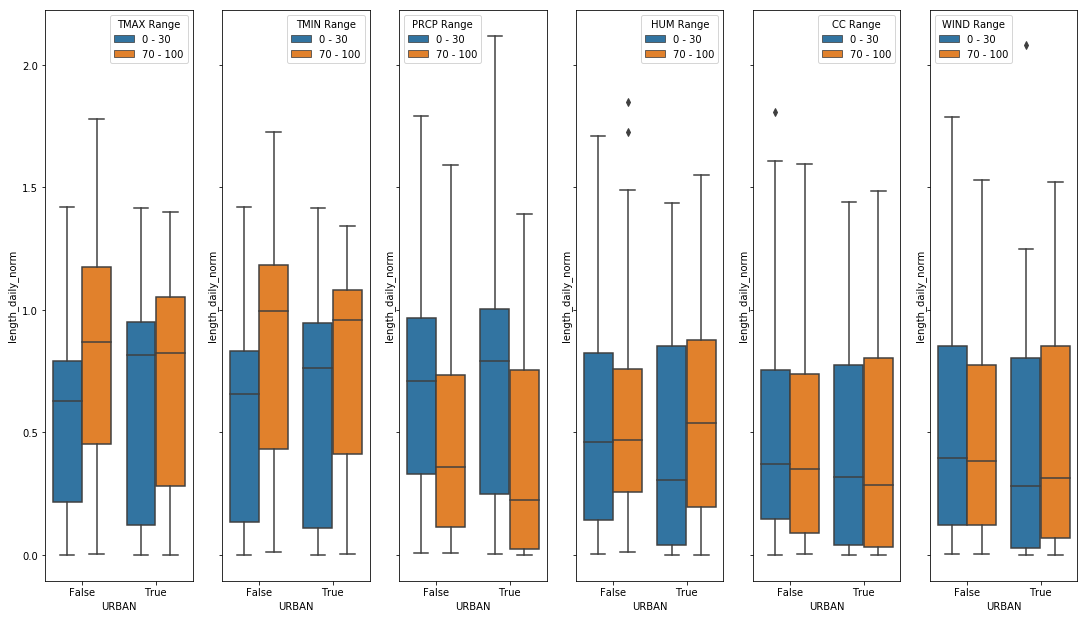

In [112]:
i=0
f, ax = plt.subplots(1, 6, sharey=True)
f.set_size_inches(18.5, 10.5, forward=True)
for weather_factor in ['TMAX','TMIN','PRCP','HUM','CC','WIND'] :
    ill_low_cc_df=ill_isum_tweets_df[ill_isum_tweets_df[weather_factor] <= ill_isum_tweets_df[weather_factor].quantile(0.3)]
    ill_high_cc_df=ill_isum_tweets_df[ill_isum_tweets_df[weather_factor] >= ill_isum_tweets_df[weather_factor].quantile(0.7)]
    
    ill_sum_low_cc_tweets_df=ill_low_cc_df.groupby([ill_low_cc_df.timestamp,ill_low_cc_df.URBAN]).length_daily.sum().to_frame().reset_index()
    ill_sum_high_cc_tweets_df=ill_high_cc_df.groupby([ill_high_cc_df.timestamp,ill_high_cc_df.URBAN]).length_daily.sum().to_frame().reset_index()
    
    ill_sum_tweets_df=ill_isum_tweets_df.groupby([ill_isum_tweets_df.timestamp,ill_isum_tweets_df.URBAN]).length_daily.sum().to_frame().reset_index()
    ill_mean_tweets_df= ill_sum_tweets_df.groupby([ill_sum_tweets_df.URBAN]).length_daily.mean().to_frame().reset_index()
    
    ill_sum_low_cc_tweets_df.timestamp=pd.to_datetime(ill_sum_low_cc_tweets_df.timestamp,format="%Y-%m-%d")
    ill_sum_low_cc_tweets_df['month']=ill_sum_low_cc_tweets_df['timestamp'].dt.month
    ill_sum_high_cc_tweets_df.timestamp=pd.to_datetime(ill_sum_high_cc_tweets_df.timestamp,format="%Y-%m-%d")
    ill_sum_high_cc_tweets_df['month']=ill_sum_high_cc_tweets_df['timestamp'].dt.month
    
    #print ill_mean_tweets_df.head()
    #ill_mean_low_cc_tweets_df= ill_sum_low_cc_tweets_df.groupby([ill_sum_low_cc_tweets_df.timestamp.dt.month, ill_sum_low_cc_tweets_df.DEN]).length_daily.mean().to_frame().reset_index()
    #ill_mean_high_cc_tweets_df= ill_sum_high_cc_tweets_df.groupby([ill_sum_high_cc_tweets_df.timestamp.dt.month, ill_sum_high_cc_tweets_df.DEN]).length_daily.mean().to_frame().reset_index()
    
    #ill_mean_low_cc_tweets_df=ill_mean_low_cc_tweets_df.rename(index=str, columns={"timestamp": "month"})
    #ill_mean_high_cc_tweets_df=ill_mean_high_cc_tweets_df.rename(index=str, columns={"timestamp": "month"})

    ill_sum_low_cc_tweets_df=pd.merge(ill_sum_low_cc_tweets_df, ill_mean_tweets_df, on=['URBAN'], how='left',suffixes=['_sum','_avg'])
    ill_sum_high_cc_tweets_df=pd.merge(ill_sum_high_cc_tweets_df, ill_mean_tweets_df, on=['URBAN'], how='left',suffixes=['_sum','_avg'])

    ill_sum_low_cc_tweets_df['length_daily_norm']=ill_sum_low_cc_tweets_df['length_daily_sum']/ill_sum_low_cc_tweets_df['length_daily_avg']
    ill_sum_high_cc_tweets_df['length_daily_norm']=ill_sum_high_cc_tweets_df['length_daily_sum']/ill_sum_high_cc_tweets_df['length_daily_avg']
    
    ill_sum_low_cc_tweets_df[weather_factor+' Range']='0 - 30'
    ill_sum_high_cc_tweets_df[weather_factor+' Range']='70 - 100'

    ill_sum_lowhigh_df=pd.concat([ill_sum_low_cc_tweets_df,ill_sum_high_cc_tweets_df])

    sns.boxplot(x='URBAN', y='length_daily_norm', hue=weather_factor+' Range',data=ill_sum_lowhigh_df,ax=ax[i])
    i=i+1

f.savefig('boxplot.png')  

In [38]:
#tweets_df.timestamp=pd.to_datetime(tweets_df.timestamp,format="%Y%m%d")
#ill_sum_tweets_df=tweets_df.groupby([tweets_df.timestamp,tweets_df.DEN]).length.sum().to_frame().reset_index()
#ill_sum_tweets_df['month']=ill_sum_tweets_df['timestamp'].dt.month


#ill_sum_tweets_df.head()

#ill_msum_tweets_df=ill_sum_tweets_df.groupby([ill_sum_tweets_df.timestamp.dt.month,ill_sum_tweets_df.DEN]).length.mean().to_frame().reset_index()
#ill_msum_tweets_df=ill_msum_tweets_df.rename(index=str, columns={"timestamp": "month"})
#ill_isum_tweets_df=pd.merge(ill_sum_tweets_df, ill_msum_tweets_df, on=['month','DEN'], how='left',suffixes=['_daily','_monthly'])
#ill_isum_tweets_df['length_norm']=ill_isum_tweets_df['length_daily']-ill_isum_tweets_df['length_monthly']
#ill_isum_tweets_df.head()

***
## Robustness Test of the Model and Data sources
***

> ** <font color=blue>Test 1.  Cross Validation Test of 2016 has been processed on server (PRISM training, GHCND testing</font> **
- The KNN is 5 , Radius is set to 10,25,50,100 for comparision (Order: TMAX, TMIN, PPT)

C:\WorkingGround\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning:

No labelled objects found. Use label='...' kwarg on individual plots.



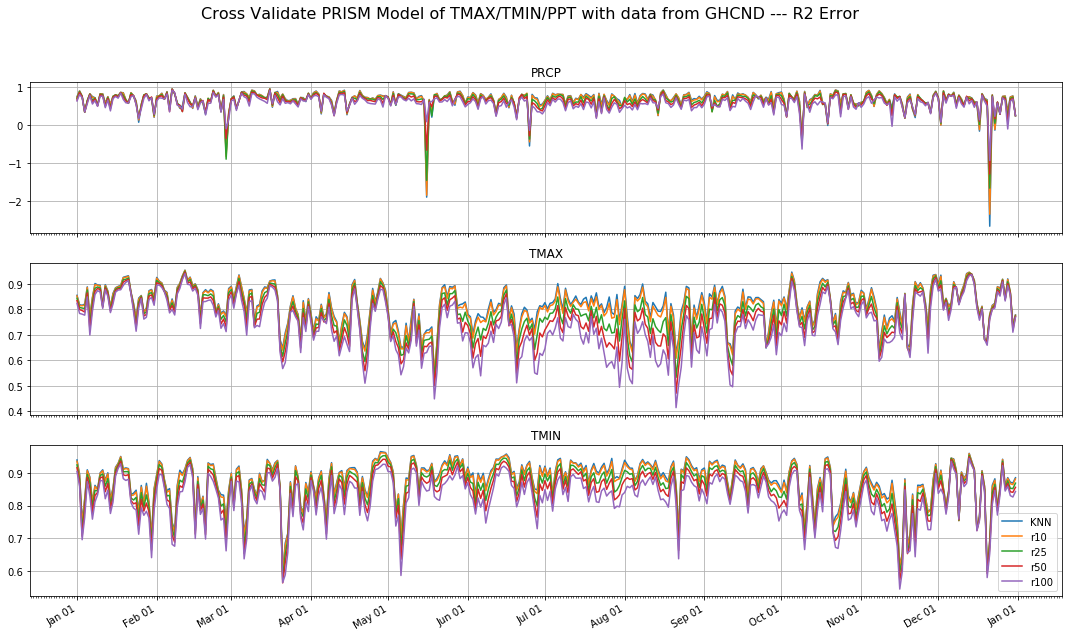

In [13]:
prism2016_results_df = pd.read_json("data\\2016_radius_scores.json", orient='records')

f, axarr = plt.subplots(3, 1, sharex=True)
f.suptitle('Cross Validate PRISM Model of TMAX/TMIN/PPT with data from GHCND --- R2 Error', fontsize=16)
f.set_size_inches(18.5, 10.5, forward=True)
i=0
#test_year=2016

#times = pd.date_range('2016-01-01', periods=366)
#time_list=np.array(times)
date_range=[d.strftime('%Y%m%d') for d in pd.date_range('20160101','20161231')]
days=DayLocator()    
months = MonthLocator()  # every month
weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
dayFormatter = DateFormatter('%d')      # e.g., 12

for column in sorted(prism2016_results_df.columns):
    normal_list=np.array(prism2016_results_df[column].tolist())
    knn_list=normal_list[:,0].tolist()   
    r10_list=normal_list[:,1].tolist()   
    r25_list=normal_list[:,2].tolist()   
    r50_list=normal_list[:,3].tolist()   
    r100_list=normal_list[:,4].tolist()   
    axarr[i].xaxis.set_major_locator(months)
    axarr[i].xaxis.set_minor_locator(days)
    axarr[i].xaxis.set_major_formatter(weekFormatter)
    axarr[i].xaxis_date()
    axarr[i].plot_date(date_range,knn_list,'-',label="KNN")
    axarr[i].plot_date(date_range,r10_list,'-',label="r10")
    axarr[i].plot_date(date_range,r25_list,'-',label="r25")
    axarr[i].plot_date(date_range,r50_list,'-',label="r50")
    axarr[i].plot_date(date_range,r100_list,'-',label="r100")
    legend()
    axarr[i].autoscale_view()
    axarr[i].grid(True)
    axarr[i].set_title(column)
    
    i=i+1
    
f.autofmt_xdate()

In [14]:
used_columns = [1,2,3,4,5,6]
dtypes = ['object']+['object']+[float]+[float, float, float]
data_columns =["GHCND","DATE","VALUE","LAT","LON","ELEV"]
year='2016'
date_range=[d.strftime('%Y%m%d') for d in pd.date_range('20160101','20161231')]


filename=r'/vsizip/C:\WorkingGround\Master Thesis\data\daily PRISM dataframes\PRISM_tmax_stable_4kmD1_20160101_20161231_bil.zip\PRISM_tmax_stable_4kmD1_20160102_bil.bil'
gdal.GetDriverByName('EHdr').Register()
Regressor='Radius'
n=5
img = gdal.Open(filename, GA_ReadOnly) 

file_name="2016_PRCP"
year_station_metric_df=pd.read_csv("data\\daily GHCND dataframes\\"+file_name+".csv",skipinitialspace=True,header=None,usecols = used_columns,
                              dtype=dict(zip(used_columns, dtypes)),sep=',').rename(columns=dict(zip(used_columns, data_columns)))

year_station_metric_df.head()

#getWeatherNormalPRIMS(date_station_sample_df,img, date, 10, 'Radius')

,GHCND,DATE,VALUE,LAT,LON,ELEV
0,US1MNWR0029,20160101,0.0,45.1841,-93.8718,307.2
1,US1MNWR0029,20160102,0.0,45.1841,-93.8718,307.2
2,US1MNWR0029,20160103,0.0,45.1841,-93.8718,307.2
3,US1MNWR0029,20160104,0.0,45.1841,-93.8718,307.2
4,US1MNWR0029,20160105,0.0,45.1841,-93.8718,307.2


In [15]:
error_dates=np.array(date_range)[np.argsort(normal_list.mean(axis=1))[:10]]
print error_dates

['20160321' '20161116' '20161220' '20161117' '20160322' '20160506'
 '20161119' '20161122' '20161221' '20160306']


In [16]:
right_dates=np.array(date_range)[np.argsort(normal_list.mean(axis=1))[-10:]].T
print right_dates

['20160511' '20160528' '20160616' '20160615' '20160118' '20161206'
 '20160428' '20160430' '20160429' '20161213']


* Print the top 10 worst and best performanced date in 2016 based on the cross validation results

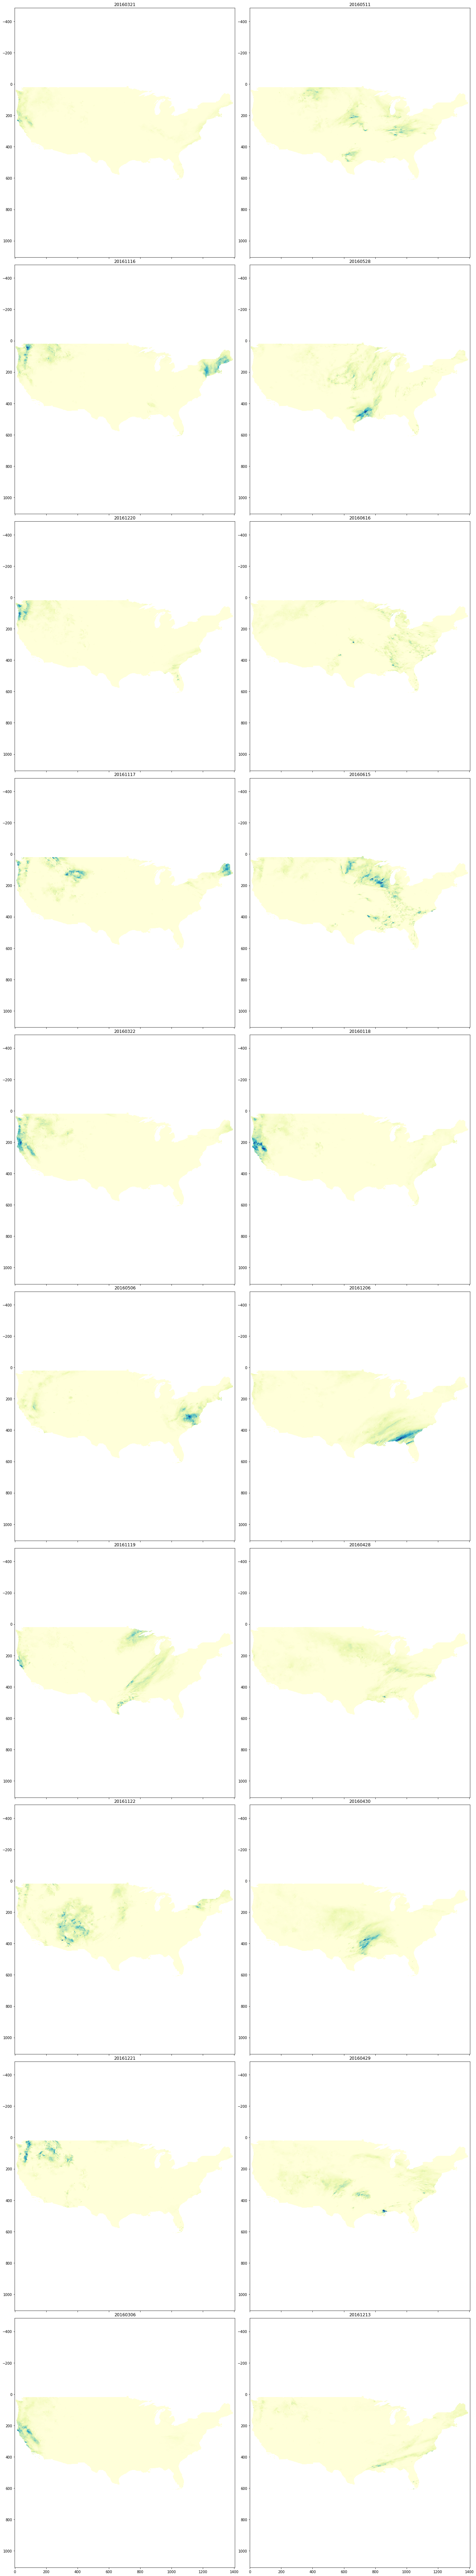

In [17]:
from folium.plugins import MarkerCluster
icon_create_function = """\
function(cluster) {
    return L.divIcon({
    html: '<b>' + cluster.getChildCount() + '</b>',
    className: 'marker-cluster marker-cluster-large',
    iconSize: new L.Point(20, 20)
    });
}"""

f, axarr = plt.subplots(10, 2, sharex=True)
f.set_size_inches(18.5, 100.5, forward=True)
f.tight_layout()
#error_date=['20161221']
#right_date=['20160316']
i=0
for error_date in error_dates:
    filename=r'/vsizip/C:\WorkingGround\Master Thesis\data\daily PRISM dataframes\PRISM_ppt_stable_4kmD2_20160101_20161231_bil.zip\PRISM_ppt_stable_4kmD2_'+error_date+'_bil.bil'
    gdal.GetDriverByName('EHdr').Register()
    Regressor='Radius'
    n=5
    img = gdal.Open(filename, GA_ReadOnly) 
    band = img.GetRasterBand(1)
    nodatavalue = band.GetNoDataValue()
    prism_array = band.ReadAsArray().astype(np.float32)
    # prism_nodata = prism_band.GetNoDataValue()
    prism_array[prism_array == nodatavalue] = np.nan
    prism_ds = None

    axarr[i][0].imshow(prism_array, cmap='YlGnBu')
    axarr[i][0].set_title(error_date)
    i=i+1

j=0
for right_date in right_dates:
    filename_right=r'/vsizip/C:\WorkingGround\Master Thesis\data\daily PRISM dataframes\PRISM_ppt_stable_4kmD2_20160101_20161231_bil.zip\PRISM_ppt_stable_4kmD2_'+right_date+'_bil.bil'
    gdal.GetDriverByName('EHdr').Register()
    img = gdal.Open(filename_right, GA_ReadOnly) 
    band = img.GetRasterBand(1)
    nodatavalue = band.GetNoDataValue()
    prism_array = band.ReadAsArray().astype(np.float32)
    # prism_nodata = prism_band.GetNoDataValue()
    prism_array[prism_array == nodatavalue] = np.nan
    prism_ds = None
    axarr[j][1].imshow(prism_array, cmap='YlGnBu')
    axarr[j][1].set_title(right_date)
    j=j+1

plt.show()

f.savefig('ghcn_top10.png')  
#date_station_error_df=year_station_metric_df[(year_station_metric_df['DATE']==error_date[0]) & (year_station_metric_df['VALUE']<1000) & (year_station_metric_df['VALUE']>-999)]
#date_station_error_df=date_station_error_df[date_station_error_df['GHCND'].isin(temp_stations_cont['GHCND'])]
#date_station_error_df=date_station_error_df.sample(n=500)
#locations=np.array(zip(date_station_error_df.LAT, date_station_error_df.LON))
#popups = ['lon:{}<br>lat:{}<br>val:{}'.format(lon, lat,date_station_error_df[(date_station_error_df['LAT']==lat) & (date_station_error_df['LON']==lon)]['VALUE'].values[0]/10 ) for (lat, lon) in locations]
#m = folium.Map(
#    location=[np.array(date_station_error_df['LAT'].tolist()).mean(), np.array(date_station_error_df['LON'].tolist()).mean()],
#    tiles='Cartodb Positron',
#    zoom_start=1
#)

#marker_cluster = MarkerCluster(
#    locations=locations, popups=popups,
#    name='1000 clustered icons',
#    overlay=True,
#    control=True,
#    icon_create_function=icon_create_function
#)

#marker_cluster.add_to(m)
#
#folium.LayerControl().add_to(m)
#
#m.save('error1.html')
#
#display(m)

#date_station_right_df=year_station_metric_df[(year_station_metric_df['DATE']==right_date[0]) & (year_station_metric_df['VALUE']<1000) & (year_station_metric_df['VALUE']>-999)]
#date_station_right_df=date_station_right_df[date_station_right_df['GHCND'].isin(temp_stations_cont['GHCND'])]
#date_station_right_df=date_station_right_df[date_station_right_df['GHCND'].isin(date_station_error_df['GHCND'])]

#print zip(getWeatherNormalPRIMS(date_station_error_df,img,error_date[0],5,'KNN'),np.array(date_station_error_df['VALUE'].tolist())/10)
#print r2_score(getWeatherNormalPRIMS(date_station_error_df,img,error_date[0],5,'KNN'), np.array(date_station_error_df['VALUE'].tolist())/10) 
#print "------------------------------------------------------------------------------------------------------------------------------------"
#print zip(getWeatherNormalPRIMS(date_station_right_df,img,right_date[0],5,'KNN'),np.array(date_station_right_df['VALUE'].tolist())/10)
#print r2_score(getWeatherNormalPRIMS(date_station_right_df,img,error_date[0],5,'KNN'), np.array(date_station_right_df['VALUE'].tolist())/10) 

<br>
> ** <font color=blue>Test 2. Three typcial cities with different meteorological signatures with data given by NCEP (Eyeball check the output with Wolfram Alpha)</font> **

In [3]:
def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print "\t\ttype:", repr(nc_fid.variables[key].dtype)
            for ncattr in nc_fid.variables[key].ncattrs():
                print '\t\t%s:' % ncattr,\
                      repr(nc_fid.variables[key].getncattr(ncattr))
        except KeyError:
            print "\t\tWARNING: %s does not contain variable attributes" % key

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print "NetCDF Global Attributes:"
        for nc_attr in nc_attrs:
            print '\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print "NetCDF dimension information:"
        for dim in nc_dims:
            print "\tName:", dim 
            print "\t\tsize:", len(nc_fid.dimensions[dim])
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print "NetCDF variable information:"
        for var in nc_vars:
            if var not in nc_dims:
                print '\tName:', var
                print "\t\tdimensions:", nc_fid.variables[var].dimensions
                print "\t\tsize:", nc_fid.variables[var].size
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

In [19]:
year='2016'
start_date=year+'0101'
end_date=year+'1231'
hum_year=Dataset('data\\daily NCEP dataframes\\rhum.'+year+'.nc')
nc_attrs, nc_dims, nc_vars = ncdump(hum_year)

print "********************************************************* SPLIT ****************************************************************"
cc_year=Dataset('data\\daily NCEP dataframes\\tcdc.eatm.gauss.'+year+'.nc')
nc_attrs, nc_dims, nc_vars = ncdump(cc_year)
print "********************************************************* SPLIT ****************************************************************"
vw_year=Dataset('data\\daily NCEP dataframes\\vwnd.10m.gauss.'+year+'.nc')
uw_year=Dataset('data\\daily NCEP dataframes\\uwnd.10m.gauss.'+year+'.nc')
wind_year=dict()
wind_year['uwnd']=uw_year
wind_year['vwnd']=vw_year
nc_attrs, nc_dims, nc_vars = ncdump(vw_year)
nc_attrs, nc_dims, nc_vars = ncdump(uw_year)

data_year_dict=dict()
data_year_dict['HUM']=hum_year
data_year_dict['CC']=cc_year
data_year_dict['WIND']=wind_year

NetCDF Global Attributes:
	Conventions: u'CF-1.0'
	title: u'mean daily NCEP/DOE Reanalysis 2'
	history: u'created 2016/07 by NOAA/ESRL/PSD'
	comments: u'Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)\n(4x/day).  It consists of most variables interpolated to\npressure surfaces from model (sigma) surfaces.'
	platform: u'Model'
	source: u'NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model'
	institution: u'National Centers for Environmental Prediction'
	dataset_title: u'NCEP-DOE AMIP-II Reanalysis'
	References: u'https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis2.html'
	source_url: u'http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/'
NetCDF dimension information:
	Name: lon
		size: 144
		type: dtype('float32')
		units: u'degrees_east'
		long_name: u'Longitude'
		actual_range: array([   0. ,  357.5], dtype=float32)
		standard_name: u'longitude'
		axis: u'X'
		coordinate_defines: u'point'
	Name: lat
		size: 73
		type: dtype('float32')
		units: u'degrees_north'


In [20]:
date_range=np.array([d.strftime('%Y%m%d') for d in pd.date_range(start_date,end_date)])
#for date in date_range:
df=pd.DataFrame({'LAT': [47.6062,40.7128,33.448376], 'LON':[-122.3321, -74.0060,-112.074036]})  #Seatlle, New York, Pheonix

nyc_chi_dict=defaultdict(list)
for key in ['HUM','CC','WIND']:
    key_list=list()
    for date in date_range:
        key_list.append(getWeatherNormalNCEP(df,data_year_dict[key], key,date))
    nyc_chi_dict[key]=key_list

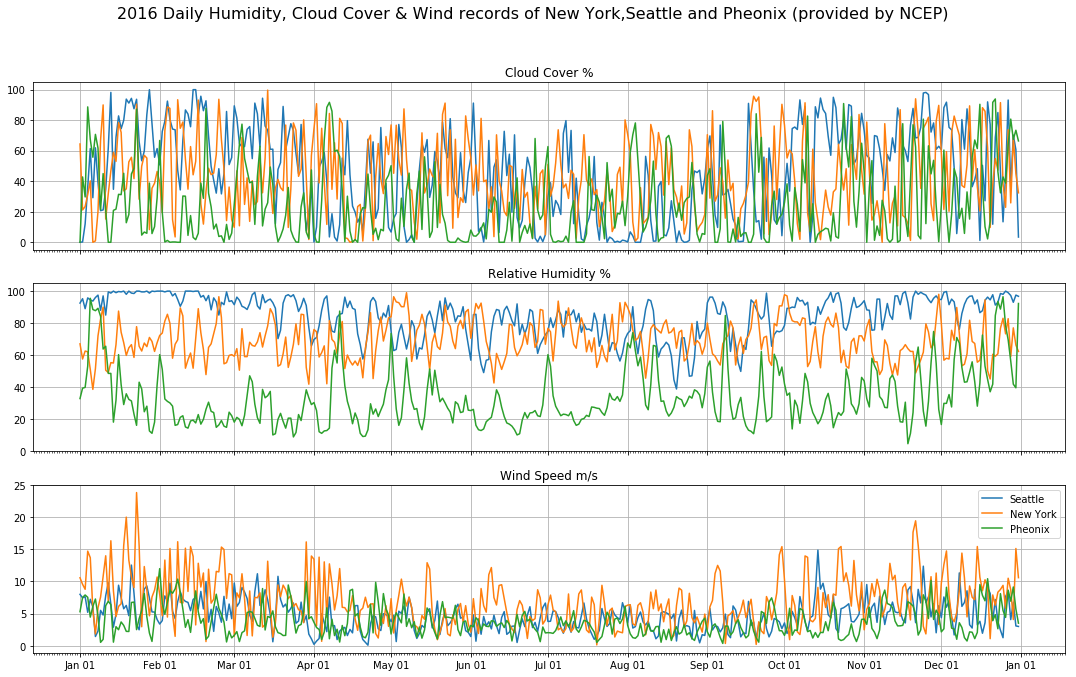

In [21]:
f, axarr = plt.subplots(3, 1, sharex=True)
f.suptitle('2016 Daily Humidity, Cloud Cover & Wind records of New York,Seattle and Pheonix (provided by NCEP)', fontsize=16)
f.set_size_inches(18.5, 10.5, forward=True)
i=0
date_range=[d.strftime('%Y%m%d') for d in pd.date_range(start_date,end_date)]
days=DayLocator()    
months = MonthLocator()  # every month
weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
dayFormatter = DateFormatter('%d')      # e.g., 12

for key in nyc_chi_dict.keys():
    axarr[i].xaxis.set_major_locator(months)
    axarr[i].xaxis.set_minor_locator(days)
    axarr[i].xaxis.set_major_formatter(weekFormatter)
    axarr[i].xaxis_date()
    axarr[i].plot_date(date_range,np.array(nyc_chi_dict[key])[:,0],'-',label="Seattle")
    axarr[i].plot_date(date_range,np.array(nyc_chi_dict[key])[:,1],'-',label="New York")
    axarr[i].plot_date(date_range,np.array(nyc_chi_dict[key])[:,2],'-',label="Pheonix")
    legend()
    axarr[i].autoscale_view()
    axarr[i].grid(True)
    if key=="CC":
        axarr[i].set_title('Cloud Cover %')
    if key=="HUM":
        axarr[i].set_title('Relative Humidity %')
    if key=="WIND":
        axarr[i].set_title('Wind Speed m/s')
    i=i+1


f.savefig('ncep_3cities.png')  

** Wolframe Alpha Humidity 2016**
<img src="wolf_hum.PNG">
<br>
** Wolframe Alpha Wind 2016**
<img src="wolf_wind.PNG">

<br>
> ** <font color=blue>Test 3.  Population Density Robustness Check </font>**

In [6]:
year="2017"

pop_den_years=np.array([2000,2005,2010,2015])
nearest_pop_year = pop_den_years[(np.abs(pop_den_years-int(year))).argmin()]

pop_file="data\\population density\\gpw-v4-population-density-rev10_"+str(nearest_pop_year)+"_30_sec_tif\\gpw_v4_population_density_rev10_"+str(nearest_pop_year)+"_30_sec.tif"

tifdump(pop_file)

#df=pd.DataFrame({'LAT': [40.785091,33.792461], 'LON':[-73.968285,-118.185005]})
pop_img = gdal.Open(pop_file)
#print "[New York  Los Angeles]",getPopDens(df, img)
#fp = open('data\\population density\\gpw-v4-population-density-rev10_2015_30_sec_tif\\gpw_v4_population_density_rev10_2015_30_sec.tif',"rb")
#pop_img = imread(pop_file)
#pop_img[]



{'STATISTICS_MEAN': '56.201003414337', 'STATISTICS_MINIMUM': '1.0000458132708e-006', 'STATISTICS_MAXIMUM': '483318.21875', 'RepresentationType': 'ATHEMATIC', 'STATISTICS_STDDEV': '446.28362269234'}
**********************
Projection: (OriginX, pixelWidth,b, OriginY, pixelHeight,d) (-180.0, 0.00833333333333286, 0.0, 84.99999999999176, 0.0, -0.00833333333333286)
('[ NO DATA VALUE ] = ', -3.4028230607370965e+38)
('[ MIN ] = ', 1.0000458132708e-06)
('[ MAX ] = ', 483318.21875)


In [291]:
#### USA bounding box
top =  42.0095 # north lat
left = -124.4096 # west long
right = -114.1308 # east long
bottom = 32.5343 # south lat
band = pop_img.GetRasterBand(1)
# Compute statistics if needed
nodatavalue = band.GetNoDataValue()

ncol = pop_img.RasterXSize
nrow = pop_img.RasterYSize
geotransform = pop_img.GetGeoTransform()
originX = geotransform[0]
pixelWidth = geotransform[1]
b=geotransform[2]
originY = geotransform[3]
d=geotransform[4]
pixelHeight = geotransform[5]   
data = band.ReadAsArray()
data[data == nodatavalue] = np.nan    
print geotransform

points_list = np.array([(top,left),(top,right),(bottom,left),(bottom,right)]) #list of X,Y coordinates
for point in points_list:
    row = int((point[0] - originY) / pixelHeight)
    col = int((point[1] - originX) / pixelWidth)
    print row, col
    
print data.shape
print data[5158:6295,6670:7904].shape

(-180.0, 0.00833333333333286, 0.0, 84.99999999999176, 0.0, -0.00833333333333286)
5158 6670
5158 7904
6295 6670
6295 7904
(17400L, 43200L)
(1137L, 1234L)


> Plot pop. density of top 100 US cities

C:\WorkingGround\Anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3222: MatplotlibDeprecationWarning:

The ishold function was deprecated in version 2.0.

C:\WorkingGround\Anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3231: MatplotlibDeprecationWarning:

axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.

C:\WorkingGround\Anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3296: MatplotlibDeprecationWarning:

The ishold function was deprecated in version 2.0.

C:\WorkingGround\Anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3305: MatplotlibDeprecationWarning:

axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.



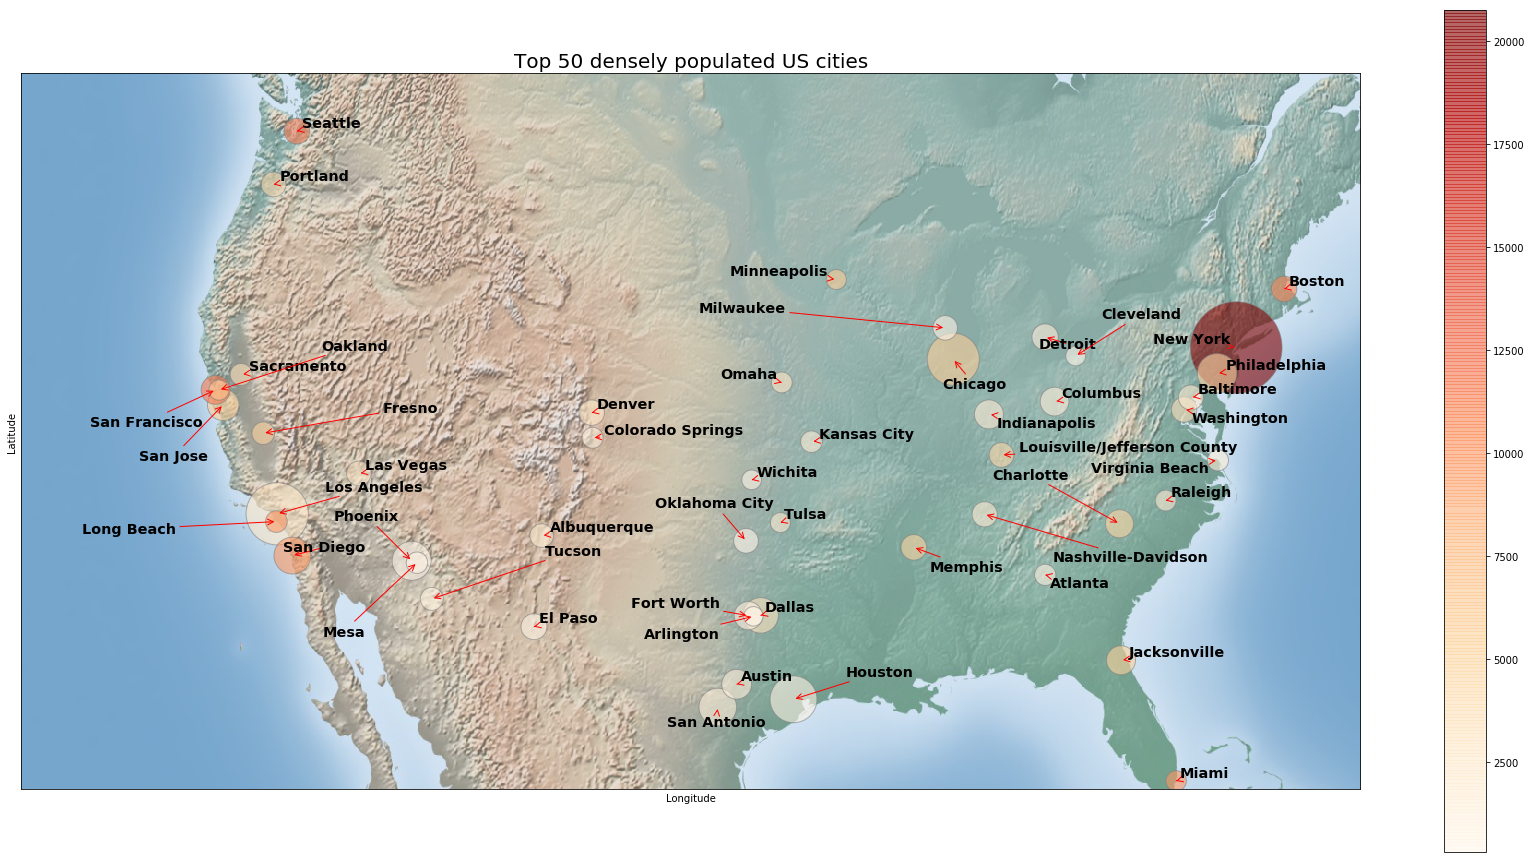

In [24]:
cities_df=pd.read_json('data//data option one//cities.json',orient="records")
top_50_cities_df=cities_df.head(50)
top_50_cities_df=top_50_cities_df.rename(index=str, columns={"latitude": "LAT", "longitude": "LON"})
top_50_cities_df['DEN']=getPopDens(top_50_cities_df,pop_img)

f, axe = plt.subplots(1, 1, sharex=True)
axe.set_title("Top 50 densely populated US cities", fontsize=20)
f.set_size_inches(30, 15.5, forward=True)
map = Basemap(llcrnrlon=-125,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

x, y = map(top_50_cities_df['LON'].tolist(), top_50_cities_df['LAT'].tolist())

scat=map.scatter(x,y, s=top_50_cities_df['population']/1000, c=top_50_cities_df['DEN'], cmap="OrRd", alpha=0.6, edgecolors="grey", linewidth=1)

font0 = FontProperties()
font0.set_size('x-large')
font0.set_weight('bold')
texts = [axe.text(x, y, label,fontproperties=font0, ha='center', va='center') for label, x, y in zip(top_50_cities_df['city'], x, y)]
adjust_text(texts, force_text=3, arrowprops=dict(arrowstyle='->', color='red')) 
# Add titles (main and on axis)
#divider = make_axes_locatable(scat)
#cax = divider.append_axes("right", size="5%", pad=0.05)

f.colorbar(scat,ax=axe)
axe.set_aspect('auto')
axe.set_xlabel("Longitude")
axe.set_ylabel("Latitude")

map.shadedrelief()

plt.show()
f.tight_layout()
f.savefig('top50_pd.png')  

##### TEST code below

find anormalies TEST!!!!!!!>!

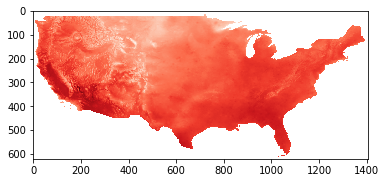

In [195]:
filename=r'/vsizip/C:\WorkingGround\Master Thesis\data\daily PRISM dataframes\PRISM_tmax_stable_4kmD1_20160101_20161231_bil.zip\PRISM_tmax_stable_4kmD1_20160601_bil.bil'
gdal.GetDriverByName('EHdr').Register()
Regressor='Radius'
n=5
img = gdal.Open(filename, GA_ReadOnly) 
band = img.GetRasterBand(1)
nodatavalue = band.GetNoDataValue()
prism_array = band.ReadAsArray().astype(np.float32)
# prism_nodata = prism_band.GetNoDataValue()
prism_array[prism_array == nodatavalue] = np.nan
prism_ds = None
f, axe = plt.subplots(1, 1, sharex=True)
axe.imshow(prism_array, cmap='Reds')
plt.show()
f.savefig('tmax_20160601.png',bbox_inches='tight', pad_inches=0)

In [272]:
gdal.SetConfigOption('OGR_INTERLEAVED_READING', 'YES')
osm = ogr.Open(r'C:\WorkingGround\Master Thesis\data\street map\north-america-latest.osm.pbf')

# Grab available layers in file
nLayerCount = osm.GetLayerCount()

thereIsDataInLayer = True

pubs = []

while thereIsDataInLayer:

    thereIsDataInLayer = False

    # Cycle through available layers
    for iLayer in xrange(nLayerCount):

        lyr=osm.GetLayer(iLayer)

        # Get first feature from layer
        feat = lyr.GetNextFeature()

        while (feat is not None):

            thereIsDataInLayer = True

             #Do something with feature, in this case store them in a list
            if feat.GetField('amenity') == 'pub':
                pubs.append(feat)

             #The destroy method is necessary for interleaved reading
            feat.Destroy()

            feat = lyr.GetNextFeature()

AttributeError: 'NoneType' object has no attribute 'GetLayerCount'

In [224]:
filename_right=r'/vsizip/C:\WorkingGround\Master Thesis\data\daily PRISM dataframes\PRISM_ppt_stable_4kmD2_20160101_20161231_bil.zip\PRISM_ppt_stable_4kmD2_'+right_date+'_bil.bil'
gdal.GetDriverByName('EHdr').Register()
img = gdal.Open(filename_right, GA_ReadOnly) 
band = img.GetRasterBand(1)
print img.GetGeoTransform()
print band.ReadAsArray().shape
print img.GetGeoTransform()[0]+ img.GetGeoTransform()[1]* band.ReadAsArray().shape[1]
print img.GetGeoTransform()[3]+ img.GetGeoTransform()[5]* band.ReadAsArray().shape[0]

(-125.02083333333336, 0.0416666666667, 0.0, 49.93749999999975, 0.0, -0.0416666666667)
(621L, 1405L)
-66.4791666666
24.0625
